## Install Libraries and Dependancies

In [1]:
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Conv2D
from keras import models
from keras import layers
from zipfile import ZipFile
import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import  Dense
import numpy as np
import cv2
import pandas as pd
#import PyDAQmx as nidaq

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
#If you wanna use cuda either downgrade it to tensorflow version 2.10 and python to 3.7, or use wsl2

False
[]


## Connect Camera Card with PyDAQmx

#### Very theoretical, unable to actually test, please don't run this

In [ ]:
t = nidaq.Task()
t.CreateAIVoltageChan("Dev1/ai0", None, nidaq.DAQmx_Val_Diff, 0, 10, nidaq.DAQmx_Val_Volts, None)
t.CfgSampClkTiming("", 1000, nidaq.DAQmx_Val_Rising, nidaq.DAQmx_Val_FiniteSamps, 5000)
t.StartTask()

In [ ]:
data = np.zeros((5000,), dtype=np.float64)
read = nidaq.int32()
t.ReadAnalogF64(5000, 0.002, nidaq.DAQmx_Val_GroupByChannel,
   data, len(data), nidaq.byref(read), None)

## Importing Images Locally

In [7]:
meas_path = r'C:\Users\richa_0\Downloads\In-situ Meas Data.zip'
meltpool_folder = 'In-situ Meas Data/Melt Pool Camera'
Layer_folder = 'In-situ Meas Data/Layer Camera'

"""command_path = r'C:\Users\richa_0\Downloads\Build Command Data.zip'
AM_Gcode_folder = 'Build Command Data/AM Gcode' #Note that the AM Gcode is not intended for general use
XYPT_folder = 'Build Command Data/XYPT Commands'

original_commands = pd.read_csv(r'C:\Users\richa_0\Downloads\T500_3D_Scan_Strategies_fused_layer0025.csv')
new_column_names = ['x', 'y', 'power', 'time']
original_commands.columns = new_column_names
image_commands = np.array([])
for i, row in original_commands.iterrows():
    if row['time'] == 2:
        image_commands = np.append(image_commands, i) """

#### Define Methods

In [8]:
def load_and_preprocess_data(zip_ref, file_prefix):
    files = [file for file in zip_ref.namelist() if file.startswith(file_prefix) and file.endswith('.bmp')]
    images = []
    for file in files:
        with zip_ref.open(file) as file_data:
            # Load image using OpenCV
            image_cv2 = cv2.imdecode(np.frombuffer(file_data.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
            image_cv2 = np.clip(image_cv2, 0, 255).astype(np.uint8)
            # Resize and normalize the image
            resized_image = cv2.resize(image_cv2, (120, 128))
            normalized_image = resized_image / 255.0
            images.append(normalized_image)

    return np.array(images)

with ZipFile(meas_path, 'r') as zip_ref:
    train_set = load_and_preprocess_data(zip_ref, "In-situ Meas Data/Melt Pool Camera/MIA_L0001")
    validation_set = load_and_preprocess_data(zip_ref, "In-situ Meas Data/Melt Pool Camera/MIA_L0013")
    test_set = load_and_preprocess_data(zip_ref, "In-situ Meas Data/Melt Pool Camera/MIA_L0025")

In [9]:
def find_area_meltpool(meltpool_image):
    meltpool_image = (meltpool_image * 255).astype(np.uint8)
    _, binary_image_80 = cv2.threshold(meltpool_image, 150, 255, cv2.THRESH_BINARY)
    contours_80, _ = cv2.findContours(binary_image_80, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contour_image_80 = np.zeros_like(meltpool_image)
    #contour_image_80 = cv2.drawContours(contour_image_80, contours_80, -1, (255), 1)
    contour_area_80 = []
    for contour in contours_80:
        area = cv2.contourArea(contour)
        contour_area_80.append(area)
    total_area_mm = sum(contour_area_80) * 0.000065
    return total_area_mm

def get_area_list(train_set):
    area_label_list = []
    for image in train_set:
        area_label_list.append(find_area_meltpool(image))
    area_label_list = np.array(area_label_list)
    return area_label_list

def classify_area_meltpool(area_label_list):
    area_classification_list = []
    for label in area_label_list:
        if label == 0:
            area_classification_list.append(0)
        elif label < 0.011:
            area_classification_list.append(1)
        elif 0.011 <= label <= 0.014:
            area_classification_list.append(2)
        elif label > 0.014:
            area_classification_list.append(3)
        else:
            area_classification_list.append("Unknown")
    area_classification_list = np.array(area_classification_list)
    return area_classification_list

def downsize_images(train_set):
    resized_images = []
    for i in range(len(train_set)):
        resized_images.append(cv2.resize(train_set[i], (30, 32)))
    return np.array(resized_images)

#### Running Model

In [10]:
train_areas = get_area_list(train_set)
train_classifications = classify_area_meltpool(train_areas)
downsized_train = downsize_images(train_set)

validation_areas = get_area_list(validation_set)
validation_classifications = classify_area_meltpool(validation_areas)
downsized_validation = downsize_images(validation_set)

test_areas = get_area_list(test_set)
test_classifications = classify_area_meltpool(test_areas)

downsized_test = downsize_images(test_set)

#### AI model made with ChatGPT

In [48]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 30, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(downsized_train, train_classifications, epochs=10, batch_size=32, validation_data=(downsized_validation, validation_classifications))

Epoch 1/10
84/84 [==============================] - 1s 11ms/step - loss: 0.9153 - accuracy: 0.6430 - val_loss: 1.1458 - val_accuracy: 0.2988
Epoch 2/10
84/84 [==============================] - 1s 9ms/step - loss: 0.6726 - accuracy: 0.7080 - val_loss: 0.4345 - val_accuracy: 0.8601
Epoch 3/10
84/84 [==============================] - 1s 9ms/step - loss: 0.4286 - accuracy: 0.8174 - val_loss: 0.9761 - val_accuracy: 0.4759
Epoch 4/10
84/84 [==============================] - 1s 9ms/step - loss: 0.3290 - accuracy: 0.8587 - val_loss: 0.3583 - val_accuracy: 0.8506
Epoch 5/10
84/84 [==============================] - 1s 9ms/step - loss: 0.3429 - accuracy: 0.8527 - val_loss: 0.3207 - val_accuracy: 0.8695
Epoch 6/10
84/84 [==============================] - 1s 9ms/step - loss: 0.2543 - accuracy: 0.8963 - val_loss: 0.2457 - val_accuracy: 0.8870
Epoch 7/10
84/84 [==============================] - 1s 9ms/step - loss: 0.2607 - accuracy: 0.8873 - val_loss: 0.2315 - val_accuracy: 0.8957
Epoch 8/10
84/84 [=

#### AI model made from research paper

In [31]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 30, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(downsized_train, train_classifications, epochs=20, batch_size=16, validation_data=(downsized_validation, validation_classifications))

Epoch 1/20
167/167 [==============================] - 4s 23ms/step - loss: 0.7056 - accuracy: 0.7230 - val_loss: 0.4683 - val_accuracy: 0.8271
Epoch 2/20
167/167 [==============================] - 4s 23ms/step - loss: 0.3547 - accuracy: 0.8546 - val_loss: 0.4232 - val_accuracy: 0.8373
Epoch 3/20
167/167 [==============================] - 4s 24ms/step - loss: 0.2692 - accuracy: 0.8918 - val_loss: 0.3233 - val_accuracy: 0.8521
Epoch 4/20
167/167 [==============================] - 4s 24ms/step - loss: 0.2018 - accuracy: 0.9177 - val_loss: 0.2888 - val_accuracy: 0.8707
Epoch 5/20
167/167 [==============================] - 4s 24ms/step - loss: 0.2014 - accuracy: 0.9158 - val_loss: 0.3366 - val_accuracy: 0.8476
Epoch 6/20
167/167 [==============================] - 4s 24ms/step - loss: 0.1742 - accuracy: 0.9297 - val_loss: 0.5062 - val_accuracy: 0.7747
Epoch 7/20
167/167 [==============================] - 4s 24ms/step - loss: 0.1836 - accuracy: 0.9237 - val_loss: 0.8524 - val_accuracy: 0.6849

#### Predict all the images in parallel

In [42]:
predictions = model.predict(downsized_test)
predictions.shape

83/83 [==============================] - 0s 2ms/step


(2645, 4)

#### Predict images in batches of 10

In [49]:
num_images = downsized_test.shape[0]
images_per_array = 10

split_arrays = np.array_split(downsized_test, num_images // images_per_array)

predictions = []

for array in split_arrays:
    prediction = model.predict(array)
    for image in prediction:
        predictions.append(image)

1/1 [==============================] - 0s 15ms/step


In [29]:
np.shape(predictions)

(2645, 4)

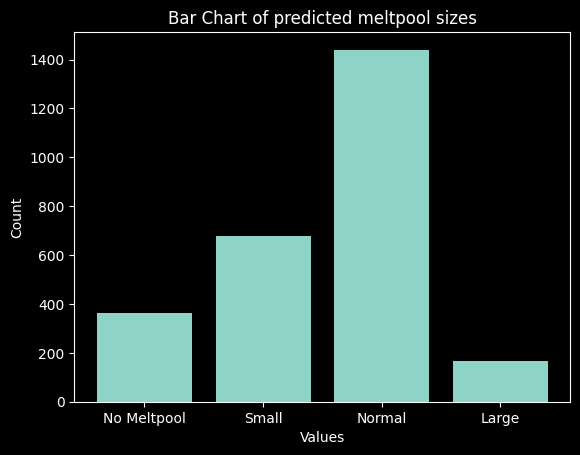

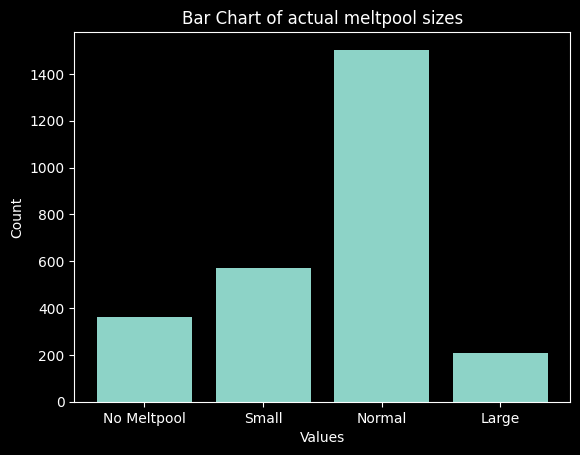

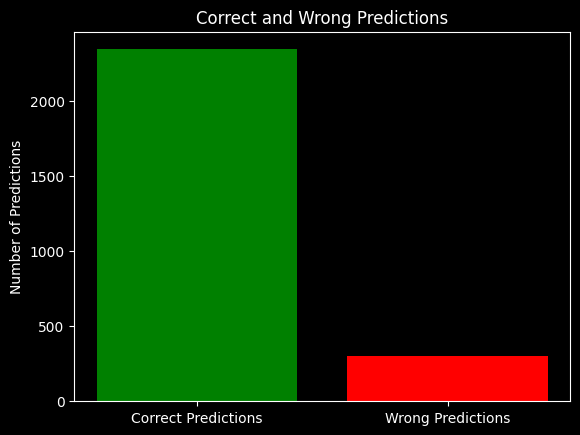

Accuracy: 88.62%


In [50]:
predictions[1000]

predictions_number = np.argmax(np.array(predictions), axis=1)
predictions_number[1000]

counts = np.bincount(predictions_number.astype(int))

plt.style.use('dark_background')

# Create a bar chart
labels = ['No Meltpool', 'Small', 'Normal', 'Large']
plt.bar(labels, counts[0:len(labels)])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Bar Chart of predicted meltpool sizes')
plt.show()

counts = np.bincount(test_classifications.astype(int))

# Create a bar chart
labels = ['No Meltpool', 'Small', 'Normal', 'Large']
plt.bar(labels, counts[0:len(labels)])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Bar Chart of actual meltpool sizes')
plt.show()

wrong_predictions = np.where(predictions_number != test_classifications)[0]

# Count the number of correct and wrong predictions
num_correct = len(test_classifications) - len(wrong_predictions)
num_wrong = len(wrong_predictions)

# Data for the bar chart
labels = ['Correct Predictions', 'Wrong Predictions']
values = [num_correct, num_wrong]

# Plotting
fig, ax = plt.subplots()
ax.bar(labels, values, color=['green', 'red'])

# Add labels and title
ax.set_ylabel('Number of Predictions')
ax.set_title('Correct and Wrong Predictions')

# Show the plot
plt.show()

correct_predictions = np.sum(predictions_number == test_classifications)

# Calculate the total number of predictions
total_predictions = len(test_classifications)

# Calculate the accuracy
accuracy = (correct_predictions / total_predictions) * 100

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}%")